# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import re
import datetime

from statistics import mean
from scipy.stats import mode
from numpy import nanmedian
from IPython.display import display
from textblob import TextBlob
# import geonamescache

# Classes

In [2]:
class Sentiment:
    def __init__(self, polarity, subjectivity):
        self.polarity = polarity
        self.subjectivity = subjectivity

# Functions

In [3]:
def fillna_median(df, col):
    """
    Function fills NaN values in column of df with MEDIAN value.
    :param col: Column to replace NaN with median
    :param df: Dataframe with specified column
    """
    df.fillna({col : df[col].median()}, inplace=True)

def fillna_mean(df, col):
    """
    Function fills NaN values in column of df with MEAN value.
    :param col: Column to replace NaN with mean
    :param df: Dataframe with specified column
    """
    df.fillna({col : df[col].mean()}, inplace=True)

def fill_df_IQR_outliers_median(df, col):
    """
    Function defines and fills outliers in column of df with MEDIAN value based on IQR criterion.
    :param col: Column to replace outliers with median
    :param df: Dataframe with specified column
    """
    q1, q3 = df[col].quantile([0.25, 0.75])
    IQR = q3 - q1
    df.loc[~df[col].between(q1-1.5*IQR, q3+1.5*IQR), col] = df[col].median()

def fill_series_IQR_outliers_median(series):
    """
    Function defines and fills outliers in series with MEDIAN value based on IQR criterion.
    :param series: Series to replace outliers with median
    """
    q1, q3 = series.quantile([0.25, 0.75])
    IQR = q3 - q1
    series.loc[~series.between(q1-1.5*IQR, q3+1.5*IQR)] = series.median()

def fill_series_IQR_outliers_nanmedian(series):
    """
    Function defines and fills outliers in series with MEDIAN value (omitting NaNs) based on IQR criterion.
    :param series: Series to replace outliers with median
    """
    q1, q3 = series.quantile([0.25, 0.75])
    IQR = q3 - q1
    series.loc[~series.between(q1-1.5*IQR, q3+1.5*IQR)] = nanmedian(series)

def show_boxplot(df, qual_col, y_col, showfliers=True):
    """
    Show boxplots for every qualitative value in specified column
    :param showfliers: parameter for show/hide outliers
    :param df: DataFrame
    :param qual_col: Column with qualitative values
    :param y_col: y variable for boxplot
    """
    n_unique = df[qual_col].nunique()
    fig, ax = plt.subplots(figsize = (1.5*n_unique, 10))
    sb.boxplot(x=qual_col, y=y_col, data=df, ax=ax, showfliers=showfliers)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + qual_col)
    plt.show()

def string_list_to_list(string_list):
    if isinstance(string_list, str):
        return re.findall('(?<=\')\w.+?(?=\')', string_list)
    return string_list

def count_cuisine(cuisine_list):
    if cuisine_list:
        return len(cuisine_list)
    else:
        return 1

def get_reviews_date_list(review_cell):
    if not isinstance(review_cell, str):
        return []

    reviews_date_text = re.search('(?<=, \[).*(?=]])', review_cell).group(0)
    date_text_list = re.findall('\d{1,2}/\d{1,2}/\d{1,4}', reviews_date_text)
    return [datetime.datetime.strptime(date_text, '%m/%d/%Y') for date_text in date_text_list]

def get_reviews_span(date_list):
    if len(date_list) > 1:
        return abs(date_list[0] - date_list[1]).days
    return np.nan

def get_review_sentiment(review_cell):
    if not isinstance(review_cell, str):
        return None

    reviews_text = re.search('(?<=\[\[).*(?=],)', review_cell).group(0)
    reviews = re.findall('(?<=\')[\w ]*?(?=\')', reviews_text)
    sentiment_list = [TextBlob(review).sentiment for review in reviews]

    if sentiment_list:
        polarity = mean([s.polarity for s in sentiment_list])
        subjectivity = mean([s.subjectivity for s in sentiment_list])
        return Sentiment(polarity, subjectivity)
    else:
        return None

def preproc_data(df_in):
    """
    All-in-one function which contains code presented in the cells below.
    We can choose how to get preprocessed data in "Model training->Define preprocessed data" section.
    So after section "Data loading" you should choose a way for data preprocessing -
    via cells run in a chain or via this function
    """

    df_out = df_in.copy()

    # Adding new features to data frame
    # Add NaN flag column for existing features
    df_out['Number_of_Reviews_isNAN'] = pd.isna(df_out['Number of Reviews']).astype('uint8')
    df_out['Cuisine_Style_isNAN'] = pd.isna(df_out['Cuisine Style']).astype('uint8')
    df_out['Price_Range_isNAN'] = pd.isna(df_out['Price Range']).astype('uint8')

    # Add numeric Price Range column (NF here and below stands for "New Feature")
    df_out['NF_price'] = df_out['Price Range'].replace({'$':1, '$$ - $$$':2, '$$$$':3})
    # print(df_out['Price Range'].value_counts(dropna=False))
    # print(df_out['NF_price'].value_counts(dropna=False))
    
    # replace NaN values with city's mode (the smallest one if many)
    city_price_mode = df_out.groupby('City')['NF_price'].agg(lambda p: mode(p)[0][0])
    df_out['NF_price'] = df_out[['City', 'NF_price']]\
                        .apply(lambda elms: city_price_mode[elms[0]] if pd.isna(elms[1]) else elms[1], axis=1)
    
    # Add number of cuisine column
    df_out['NF_cuisine_count'] = df_out['Cuisine Style'].apply(string_list_to_list).apply(lambda el: len(el) if isinstance(el, list) else el)
    
    # replace NaN values with city's mode (the smallest one if many)
    city_cuisine_count_mode = df_out.groupby('City')['NF_cuisine_count'].agg(lambda p: mode(p)[0][0])
    df_out['NF_cuisine_count'] = df_out[['City', 'NF_cuisine_count']]\
                                .apply(lambda elms: city_cuisine_count_mode[elms[0]] if pd.isna(elms[1]) else elms[1], axis=1)

    # Add column with number of cities in which restaurants of this network are presented
    restaurant_city_count = df_out.groupby('Restaurant_id')['City'].count()
    df_out['NF_city_count'] = df_out['Restaurant_id'].replace(restaurant_city_count)

    # Add column with review data span
    review_date_col = df_out['Reviews'].apply(get_reviews_date_list)
    review_span_col = review_date_col.apply(get_reviews_span)

    # plt.figure(0)
    # print(review_span_col.value_counts(dropna=False))
    # print(review_span_col.sort_values(ascending=False))
    # review_span_col.hist(bins=100)

    df_out['NF_review_span'] = review_span_col

    # let's check if there are significant differences in review span among cities
    #show_boxplot(df_out, 'City', 'NF_review_span', showfliers=False)

    # there are some differences, so let's replace outliers and NaN "city-wise"
    cities = df_out['City'].unique()

    for city in cities:
        city_review_span = df_out[df_out['City'] == city]['NF_review_span']
        city_median = nanmedian(city_review_span)
        q1, q3 = city_review_span.quantile([0.25, 0.75])
        IQR = q3 - q1
        # raplace outlier and NaN with this city median
        df_out.loc[(df_out.City == city)
               & (np.isnan(df_out.NF_review_span) | ~(df_out.NF_review_span.between(q1-1.5*IQR, q3+1.5*IQR))), 'NF_review_span'] \
          = city_median

    # plt.figure(1)
    # print(df_out['NF_review_span'].value_counts(dropna=False))
    # print(df_out['NF_review_span'].sort_values(ascending=False))
    # df_out['NF_review_span'].hist(bins=100)

    # Add columns with sentiment analysis parameters
    sentiments_col = df_out['Reviews'].apply(get_review_sentiment)
    df_out['NF_reveiw_polarity'] = sentiments_col.apply(lambda s: s.polarity if s is not None else np.nan)
    df_out['NF_reveiw_subjectivity'] = sentiments_col.apply(lambda s: s.subjectivity if s is not None else np.nan)

    # fill NaN with neutral polarity (0) and moderate subjectivity (0.5)
    df_out['NF_reveiw_polarity'].fillna(0, inplace=True)
    df_out['NF_reveiw_subjectivity'].fillna(0.5, inplace=True)

    # Add dummy cities columns
    dummy_cities = pd.get_dummies(df_out['City'], prefix='City')
    df_out = pd.concat([df_out, dummy_cities], axis=1)


    # Add dummy cuisines
    cuisine_col = df_out['Cuisine Style'].apply(string_list_to_list)
    cuisine_freq = cuisine_col.explode().value_counts()

    # replace empty cuisine lists with 3 most frequent cuisines
    nan_cuisines = cuisine_col.isna()
    cuisine_col.loc[nan_cuisines] = [list(cuisine_freq.head(3).index)] * nan_cuisines.sum()

    # get some most frequent cuisine for dummy columns
    n_cuisines = 30
    cuisine_list = list(cuisine_freq.head(n_cuisines).index)
    # print(cuisine_list)
    # print(cuisine_col)

    for cuisine in cuisine_list:
        df_out['Cuisine_'+cuisine] = cuisine_col.apply(lambda x: 1 if cuisine in x else 0)

    # Add relational rank within city
    df_tmp = df_out.groupby(['City'])['Ranking'].max().to_frame().reset_index()
    df_tmp.columns = ['City','City_N_Rank']
    df_out = df_out.merge(df_tmp, on = 'City', how = 'left')
    df_out['Ranking_rel'] = df_out['Ranking'] / df_out['City_N_Rank']
    df_out['Ranking_rel']

    # Final preprocessing for training
    # replace existing NaN values
    fillna_mean(df_out, 'Number of Reviews')

    # keep only numeric columns
    df_out = df_out.drop(['Restaurant_id', 'City', 'Cuisine Style',
                        'Price Range', 'Reviews', 'URL_TA', 'ID_TA'], axis = 1)

    # Normalization
    cols_to_norm = ['Ranking', 'Number of Reviews', 'City_N_Rank', 'NF_review_span']

    # # mean normalization
    # df_train = (df_train-df_train.mean()) / df_train.std()

    # min-max normalization
    df_out[cols_to_norm] = (df_out[cols_to_norm]-df_out[cols_to_norm].min()) / \
                             (df_out[cols_to_norm].max()-df_out[cols_to_norm].min())
    return df_out

# Init

In [4]:
sb.set_style("darkgrid")
pd.options.display.max_colwidth = 100

# fix random seed
RANDOM_SEED = 42

# fix requirements
!pip freeze > requirements.txt

# Data loading

In [5]:
DATA_DIR = './Data'

df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

display(df_train.sample(5))
df_train.info()
display(df_train.describe())

display(df_test.sample(5))
df_test.info()

display(sample_submission.head(5))
sample_submission.info()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
28054,id_2304,Berlin,['German'],2306.0,4.0,$,13.0,"[['Incredible Value', 'Guten Apetit!'], ['04/12/2017', '09/15/2017']]",/Restaurant_Review-g187323-d8374258-Reviews-Thoben_Backwaren-Berlin.html,d8374258
19094,id_3556,Paris,"['French', 'European', 'Vegetarian Friendly']",3557.0,3.5,$$ - $$$,484.0,"[['Voo Va Boom place to eat', 'Good simple food, slightly over priced'], ['10/03/2017', '09/17/2...",/Restaurant_Review-g187147-d3487923-Reviews-L_Atelier_Renault_Cafe-Paris_Ile_de_France.html,d3487923
19474,id_912,Edinburgh,"['Cafe', 'Soups', 'Fast Food', 'Vegetarian Friendly', 'Vegan Options']",913.0,4.0,$,34.0,"[['Would go again', 'Great lunchtime buzz'], ['11/02/2017', '04/23/2017']]",/Restaurant_Review-g186525-d5098513-Reviews-Pret_A_Manger-Edinburgh_Scotland.html,d5098513
34571,id_357,Lyon,['Turkish'],358.0,4.5,$$ - $$$,72.0,"[['Perfect', 'Great Dinner'], ['10/28/2017', '10/28/2017']]",/Restaurant_Review-g187265-d6591956-Reviews-Saveurs_D_orient-Lyon_Rhone_Auvergne_Rhone_Alpes.html,d6591956
17786,id_7548,Paris,"['French', 'Vegetarian Friendly', 'Gluten Free Options']",7549.0,3.5,$,34.0,"[['Disgusting', 'horrible crepes!!!'], ['09/20/2017', '02/18/2017']]",/Restaurant_Review-g187147-d10523197-Reviews-Creperie_Elo_Parmentier-Paris_Ile_de_France.html,d10523197


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City   

,Ranking,Rating,Number of Reviews
count,40000.000000,40000.000000,37457.000000
mean,3676.028525,3.993037,124.825480
std,3708.749567,0.668417,295.666352
min,1.000000,1.000000,2.000000
25%,973.000000,3.500000,9.000000
50%,2285.000000,4.000000,33.000000
75%,5260.000000,4.500000,115.000000
max,16444.000000,5.000000,9660.000000


,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
2097,id_2097,Lyon,"['Thai', 'Fusion', 'Vietnamese', 'Vegetarian Friendly']",695.0,$$ - $$$,58.0,"[['Nice Service'], ['12/02/2016']]",/Restaurant_Review-g187265-d9597301-Reviews-Kenbo-Lyon_Rhone_Auvergne_Rhone_Alpes.html,d9597301
7321,id_7321,Berlin,['German'],4898.0,NaN,9.0,"[[], []]",/Restaurant_Review-g187323-d3136137-Reviews-Seekrug-Berlin.html,d3136137
5217,id_5217,London,"['French', 'European']",6250.0,$$ - $$$,74.0,"[['Disorganised Christmas lunch', 'Good, solid French food'], ['12/19/2017', '09/17/2017']]",/Restaurant_Review-g186338-d1017356-Reviews-Luc_s_Brasserie-London_England.html,d1017356
7912,id_7912,Hamburg,['Mediterranean'],1255.0,$$ - $$$,3.0,"[[], []]",/Restaurant_Review-g187331-d13235017-Reviews-Restaurant_IRODION-Hamburg.html,d13235017
6981,id_6981,Vienna,['Italian'],3402.0,NaN,2.0,"[[], []]",/Restaurant_Review-g190454-d7999810-Reviews-Il_Pescatore_Fischspezialitaten_Restaurant-Vienna.html,d7999810


,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [6]:
# combine train and test in one data frame
df_train['Sample'] = 1 # train mark
df_test['Sample'] = 0 # test mark
df_test['Rating'] = 0

df = df_test.append(df_train, sort=False).reset_index(drop=True)
df.to_csv(f"restaurants_all_data.csv", encoding='utf-8')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   Sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


# Preliminary EDA


<AxesSubplot:>

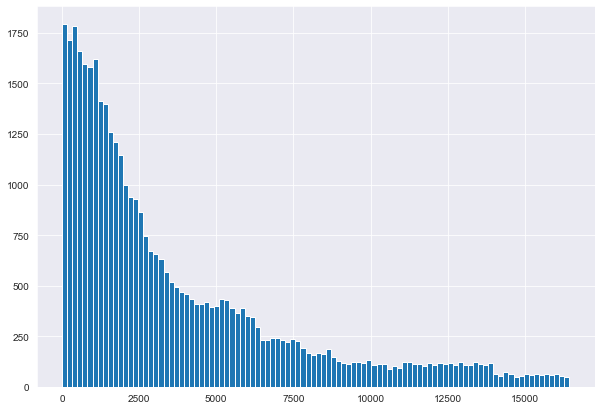

In [12]:
# ranking column
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

<AxesSubplot:>

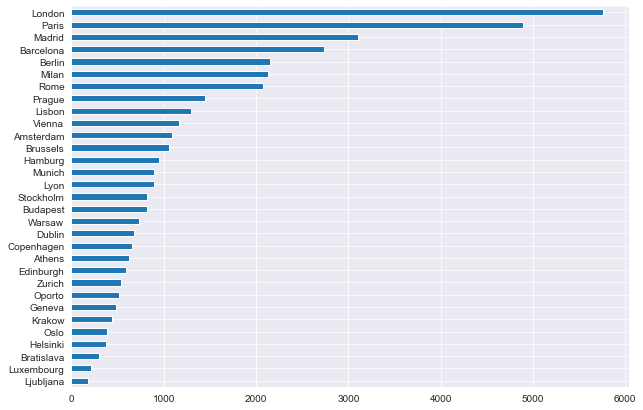

In [13]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

<AxesSubplot:>

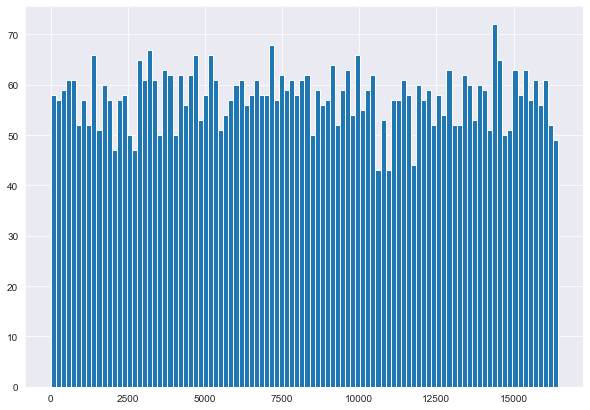

In [14]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

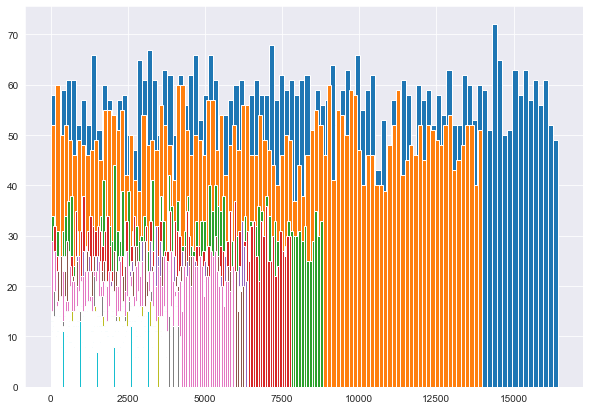

In [15]:
# top 10 city ranking histogram
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

<AxesSubplot:>

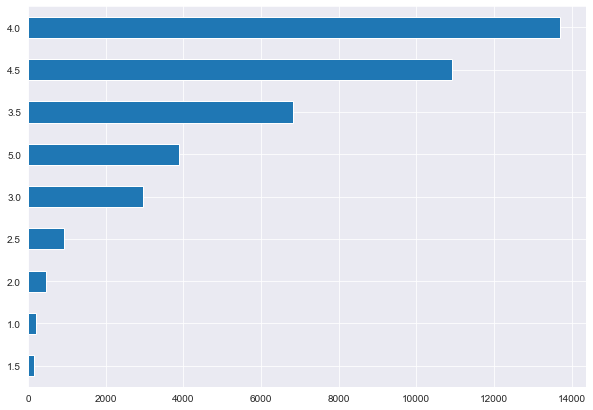

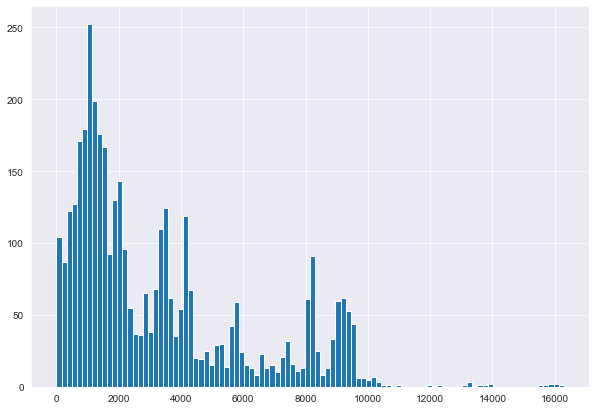

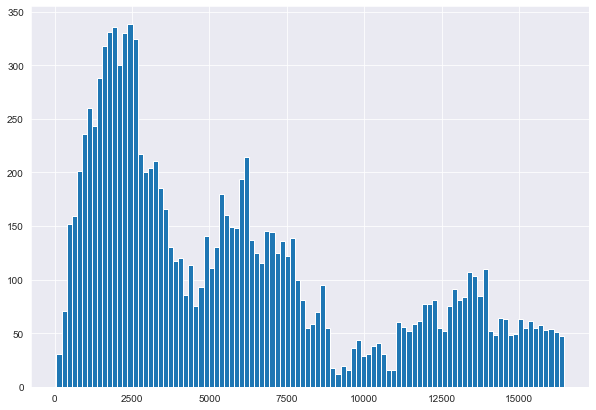

In [17]:
# target variable
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

plt.figure()
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

plt.figure()
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

# Adding new features to data frame

In [11]:
# Add NaN flag column for existing features
df['Number_of_Reviews_isNAN'] = pd.isna(df['Number of Reviews']).astype('uint8')
df['Cuisine_Style_isNAN'] = pd.isna(df['Cuisine Style']).astype('uint8')
df['Price_Range_isNAN'] = pd.isna(df['Price Range']).astype('uint8')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Restaurant_id            50000 non-null  object 
 1   City                     50000 non-null  object 
 2   Cuisine Style            38410 non-null  object 
 3   Ranking                  50000 non-null  float64
 4   Price Range              32639 non-null  object 
 5   Number of Reviews        46800 non-null  float64
 6   Reviews                  49998 non-null  object 
 7   URL_TA                   50000 non-null  object 
 8   ID_TA                    50000 non-null  object 
 9   Sample                   50000 non-null  int64  
 10  Rating                   50000 non-null  float64
 11  Number_of_Reviews_isNAN  50000 non-null  uint8  
 12  Cuisine_Style_isNAN      50000 non-null  uint8  
 13  Price_Range_isNAN        50000 non-null  uint8  
 14  NF_price              

In [8]:
# Add numeric Price Range column (NF here and below stands for "New Feature")
df['NF_price'] = df['Price Range'].replace({'$':1, '$$ - $$$':2, '$$$$':3})
print(df['Price Range'].value_counts(dropna=False))
print(df['NF_price'].value_counts(dropna=False))

# replace NaN values with city's mode (the smallest one if many)
city_price_mode = df.groupby('City')['NF_price'].agg(lambda p: mode(p)[0][0])
df['NF_price'] = df[['City', 'NF_price']]\
                    .apply(lambda elms: city_price_mode[elms[0]] if pd.isna(elms[1]) else elms[1], axis=1)
                    
print(df['NF_price'].value_counts(dropna=False))

$$ - $$$    23041
NaN         17361
$            7816
$$$$         1782
Name: Price Range, dtype: int64
2.0    23041
NaN    17361
1.0     7816
3.0     1782
Name: NF_price, dtype: int64
2.0    40402
1.0     7816
3.0     1782
Name: NF_price, dtype: int64


In [9]:
# Add number of cuisine column
df['NF_cuisine_count'] = df['Cuisine Style'].apply(string_list_to_list).apply(lambda el: len(el) if isinstance(el, list) else el)
print(df['NF_cuisine_count'].value_counts(dropna=False))

# replace NaN values with city's mode (the smallest one if many)
city_cuisine_count_mode = df.groupby('City')['NF_cuisine_count'].agg(lambda p: mode(p)[0][0])
df['NF_cuisine_count'] = df[['City', 'NF_cuisine_count']]\
                            .apply(lambda elms: city_cuisine_count_mode[elms[0]] if pd.isna(elms[1]) else elms[1], axis=1)

print(df['NF_cuisine_count'].value_counts(dropna=False))

NaN     11590
1.0      9154
2.0      7794
3.0      6638
4.0      5948
5.0      4482
6.0      2611
7.0      1294
8.0       363
9.0        93
10.0       26
11.0        4
15.0        1
13.0        1
21.0        1
Name: NF_cuisine_count, dtype: int64
1.0     17736
2.0      9796
3.0      7089
4.0      6403
5.0      4582
6.0      2611
7.0      1294
8.0       363
9.0        93
10.0       26
11.0        4
15.0        1
13.0        1
21.0        1
Name: NF_cuisine_count, dtype: int64


In [10]:
# Add column with number of cities in which restaurants of this network are presented
restaurant_city_count = df.groupby('Restaurant_id')['City'].count()
df['NF_city_count'] = df['Restaurant_id'].replace(restaurant_city_count)
print(df['NF_city_count'].head(10))

0    16
1    10
2    15
3     9
4    14
5    12
6     9
7    12
8    14
9    13
Name: NF_city_count, dtype: int64


NaN       13794
1.0         829
0.0         631
2.0         629
3.0         606
          ...  
1924.0        1
1554.0        1
1335.0        1
1576.0        1
1543.0        1
Name: Reviews, Length: 1311, dtype: int64
1966     3296.0
17990    3207.0
20997    3137.0
49997    3127.0
18356    3096.0
          ...  
49986       NaN
49988       NaN
49989       NaN
49991       NaN
49994       NaN
Name: Reviews, Length: 50000, dtype: float64
86.0     2289
99.0     2186
108.0    1471
68.0     1375
43.0     1246
         ... 
496.0       1
624.0       1
499.0       1
548.0       1
484.0       1
Name: NF_review_span, Length: 561, dtype: int64
43995    647.0
20508    636.0
4041     629.0
16308    627.0
17551    626.0
         ...  
45945      0.0
25517      0.0
7047       0.0
23234      0.0
45278      0.0
Name: NF_review_span, Length: 50000, dtype: float64


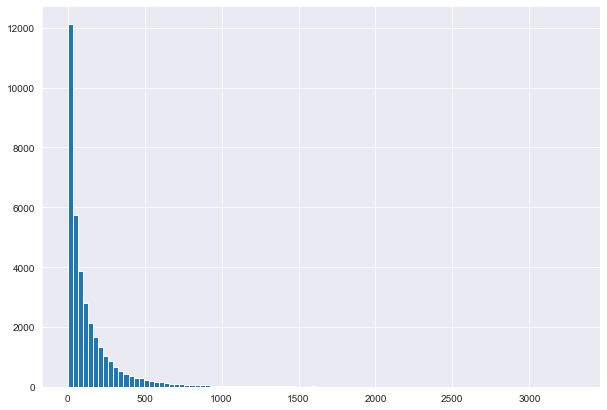

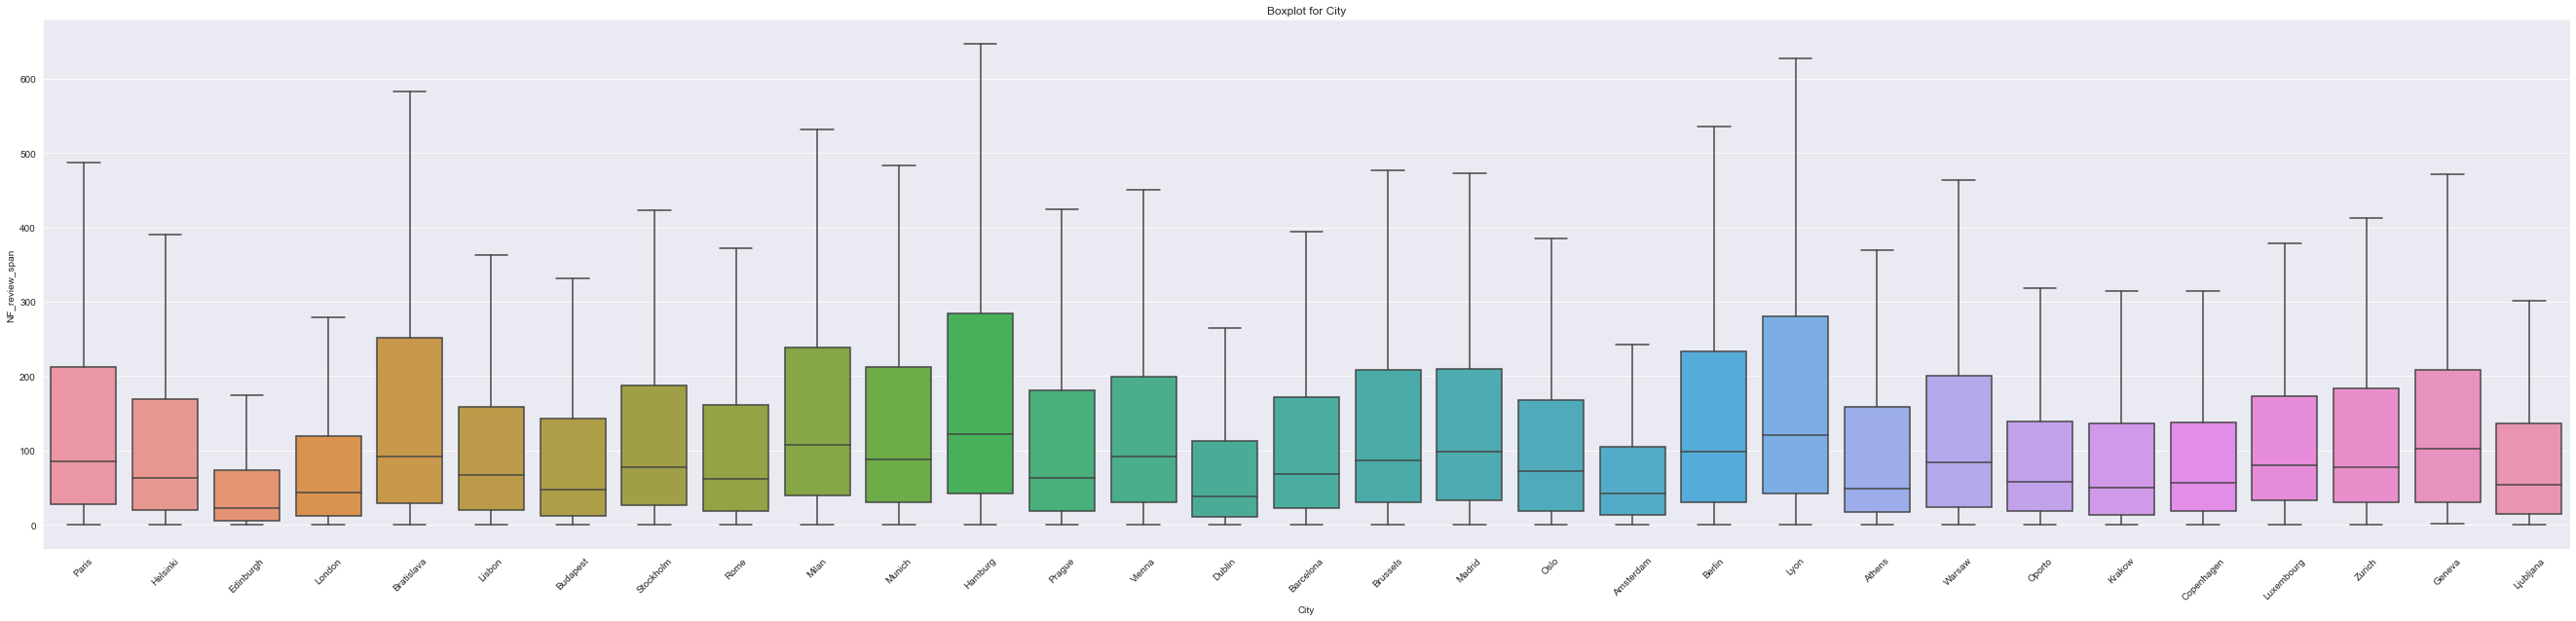

<AxesSubplot:>

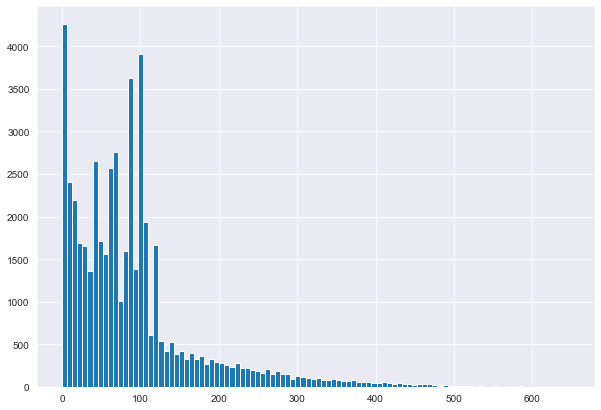

In [18]:
# Add column with review data span
review_date_col = df['Reviews'].apply(get_reviews_date_list)
review_span_col = review_date_col.apply(get_reviews_span)

plt.figure(0)
print(review_span_col.value_counts(dropna=False))
print(review_span_col.sort_values(ascending=False))
review_span_col.hist(bins=100)

df['NF_review_span'] = review_span_col

# let's check if there are significant differences in review span among cities
show_boxplot(df, 'City', 'NF_review_span', showfliers=False)

# there are some differences, so let's replace outliers and NaN "city-wise"
cities = df['City'].unique()

for city in cities:
    city_review_span = df[df['City'] == city]['NF_review_span']
    city_median = nanmedian(city_review_span)
    q1, q3 = city_review_span.quantile([0.25, 0.75])
    IQR = q3 - q1
    # raplace outlier and NaN with this city median
    df.loc[(df.City == city)
           & (np.isnan(df.NF_review_span) | ~(df.NF_review_span.between(q1-1.5*IQR, q3+1.5*IQR))), 'NF_review_span'] \
      = city_median

plt.figure(1)
print(df['NF_review_span'].value_counts(dropna=False))
print(df['NF_review_span'].sort_values(ascending=False))
df['NF_review_span'].hist(bins=100)

In [21]:
# Add columns with sentiment analysis parameters
sentiments_col = df['Reviews'].apply(get_review_sentiment)
df['NF_reveiw_polarity'] = sentiments_col.apply(lambda s: s.polarity if s is not None else np.nan)
df['NF_reveiw_subjectivity'] = sentiments_col.apply(lambda s: s.subjectivity if s is not None else np.nan)

# fill NaN with neutral polarity (0) and moderate subjectivity (0.5)
df['NF_reveiw_polarity'].fillna(0, inplace=True)
df['NF_reveiw_subjectivity'].fillna(0.5, inplace=True)

In [22]:
# Add dummy cities columns
dummy_cities = pd.get_dummies(df['City'], prefix='City')
df = pd.concat([df, dummy_cities], axis=1)

In [23]:
# Add dummy cuisines
cuisine_col = df['Cuisine Style'].apply(string_list_to_list)
cuisine_freq = cuisine_col.explode().value_counts()

# replace empty cuisine lists with 3 most frequent cuisines
nan_cuisines = cuisine_col.isna()
cuisine_col.loc[nan_cuisines] = [list(cuisine_freq.head(3).index)] * nan_cuisines.sum()

# get some most frequent cuisine for dummy columns
n_cuisines = 30
cuisine_list = list(cuisine_freq.head(n_cuisines).index)
print(cuisine_list)
print(cuisine_col)

for cuisine in cuisine_list:
    df['Cuisine_'+cuisine] = cuisine_col.apply(lambda x: 1 if cuisine in x else 0)
    print(cuisine)

['Vegetarian Friendly', 'European', 'Mediterranean', 'Italian', 'Vegan Options', 'Gluten Free Options', 'Bar', 'French', 'Asian', 'Pizza', 'Spanish', 'Pub', 'Cafe', 'Fast Food', 'British', 'International', 'Seafood', 'Japanese', 'Central European', 'American', 'Sushi', 'Chinese', 'Portuguese', 'Indian', 'Middle Eastern', 'Thai', 'Wine Bar', 'German', 'Halal', 'Greek']
0                                                                                   [Bar, Pub]
1            [European, Scandinavian, Gluten Free Options, Vegetarian Friendly, Vegan Options]
2                                                                        [Vegetarian Friendly]
3                 [Italian, Mediterranean, European, Vegetarian Friendly, Gluten Free Options]
4        [Italian, Mediterranean, European, Seafood, Vegetarian Friendly, Gluten Free Options]
                                                 ...                                          
49995                       [Italian, Vegetarian Friendly, 

In [25]:
# Add relational rank within city
df_tmp = df.groupby(['City'])['Ranking'].max().to_frame().reset_index()
df_tmp.columns = ['City','City_N_Rank']
df = df.merge(df_tmp, on = 'City', how = 'left')
df['Ranking_rel'] = df['Ranking']/df['City_N_Rank']
df['Ranking_rel']

0        0.926855
1        0.092901
2        0.458664
3        0.101496
4        0.041620
           ...   
49995    0.079681
49996    0.453382
49997    0.670455
49998    0.297586
49999    0.769243
Name: Ranking_rel, Length: 50000, dtype: float64

In [15]:
# Add columns with city info

# gc = geonamescache.GeonamesCache()
# cities_info = gc.get_cities()
# cities = df['City'].unique()
# cities
#
# city_pop_dict = {}
# cities_dict = {}
#
# for city in cities:
#     cities_dict[city] = []
#     for k,v in cities_info.items():
#         if v['name'] == city:
#             cities_dict[city].append(v)
#             # city_pop_dict[v['name']] = v['population']
# cities_dict

In [ ]:
# # process parsed data from tripadvisor.com
# import glob
#
# parsed_files = glob.glob(DATA_DIR + '/parsed_files/*.csv')
#
# li = []
#
# for filename in parsed_files:
#     cur_df = pd.read_csv(filename, index_col=None, header=0)
#     li.append(cur_df)
#
# parsed_df = pd.concat(li, axis=0, ignore_index=True)
#
# # there should be feature engineering from parsed data, but.. deadline is too close.. 8-\

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 83 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Restaurant_id                50000 non-null  object 
 1   City                         50000 non-null  object 
 2   Cuisine Style                38410 non-null  object 
 3   Ranking                      50000 non-null  float64
 4   Price Range                  32639 non-null  object 
 5   Number of Reviews            46800 non-null  float64
 6   Reviews                      49998 non-null  object 
 7   URL_TA                       50000 non-null  object 
 8   ID_TA                        50000 non-null  object 
 9   Sample                       50000 non-null  int64  
 10  Rating                       50000 non-null  float64
 11  Number_of_Reviews_isNAN      50000 non-null  uint8  
 12  Cuisine_Style_isNAN          50000 non-null  uint8  
 13  Price_Range_isNA

pandas.core.frame.DataFrame

,Ranking,Number of Reviews,Rating,Number_of_Reviews_isNAN,Cuisine_Style_isNAN,Price_Range_isNAN,NF_price,NF_cuisine_count,NF_city_count,NF_review_span,...,Cuisine_Portuguese,Cuisine_Indian,Cuisine_Middle Eastern,Cuisine_Thai,Cuisine_Wine Bar,Cuisine_German,Cuisine_Halal,Cuisine_Greek,City_N_Rank,Ranking_rel
Ranking,1.000000,-0.223775,-0.109897,0.094831,0.150058,0.233946,-0.026334,-0.356647,-0.633639,0.061997,...,-0.087233,0.052109,0.001283,-0.000618,-0.041328,-0.063743,0.040922,-0.068101,0.709068,0.570506
Number of Reviews,-0.223775,1.000000,0.011472,NaN,-0.195227,-0.254281,0.114399,0.391980,0.203630,-0.191232,...,0.028078,0.000727,-0.002821,-0.006111,0.006184,0.020880,0.009133,0.000878,0.024142,-0.400860
Rating,-0.109897,0.011472,1.000000,-0.000631,-0.010781,-0.020519,-0.012176,0.035222,0.331677,-0.028787,...,0.006840,-0.006542,0.005749,0.002007,0.017776,0.006146,-0.006682,0.009791,-0.014849,-0.168783
Number_of_Reviews_isNAN,0.094831,NaN,-0.000631,1.000000,0.187496,0.267568,0.040971,-0.159480,-0.076483,-0.044016,...,-0.022725,-0.017275,-0.016341,-0.017648,-0.021244,-0.014463,-0.028793,-0.012061,-0.024456,0.209631
Cuisine_Style_isNAN,0.150058,-0.195227,-0.010781,0.187496,1.000000,0.753183,0.157392,-0.403765,-0.130873,0.078910,...,-0.092717,-0.090736,-0.077669,-0.075332,-0.073397,-0.070930,-0.068835,-0.068608,-0.047101,0.326699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cuisine_German,-0.063743,0.020880,0.006146,-0.014463,-0.070930,-0.068044,-0.006746,0.075267,0.046042,0.002723,...,-0.020835,-0.017412,-0.015985,-0.015369,-0.005257,1.000000,-0.014904,-0.016128,-0.065353,-0.054564
Cuisine_Halal,0.040922,0.009133,-0.006682,-0.028793,-0.068835,-0.079474,-0.049156,0.167385,-0.021260,-0.025681,...,-0.015224,0.191020,0.492159,-0.007551,-0.016743,-0.014904,1.000000,-0.007742,0.101489,-0.042896
Cuisine_Greek,-0.068101,0.000878,0.009791,-0.012061,-0.068608,-0.052833,-0.034487,0.029346,0.061750,-0.015442,...,-0.021081,-0.020631,0.005804,-0.017128,-0.004300,-0.016128,-0.007742,1.000000,-0.076923,-0.036561
City_N_Rank,0.709068,0.024142,-0.014849,-0.024456,-0.047101,-0.044503,0.005115,-0.073710,-0.484354,-0.054434,...,-0.111351,0.066658,0.048061,0.017847,0.002939,-0.065353,0.101489,-0.076923,1.000000,-0.003133


<AxesSubplot:>

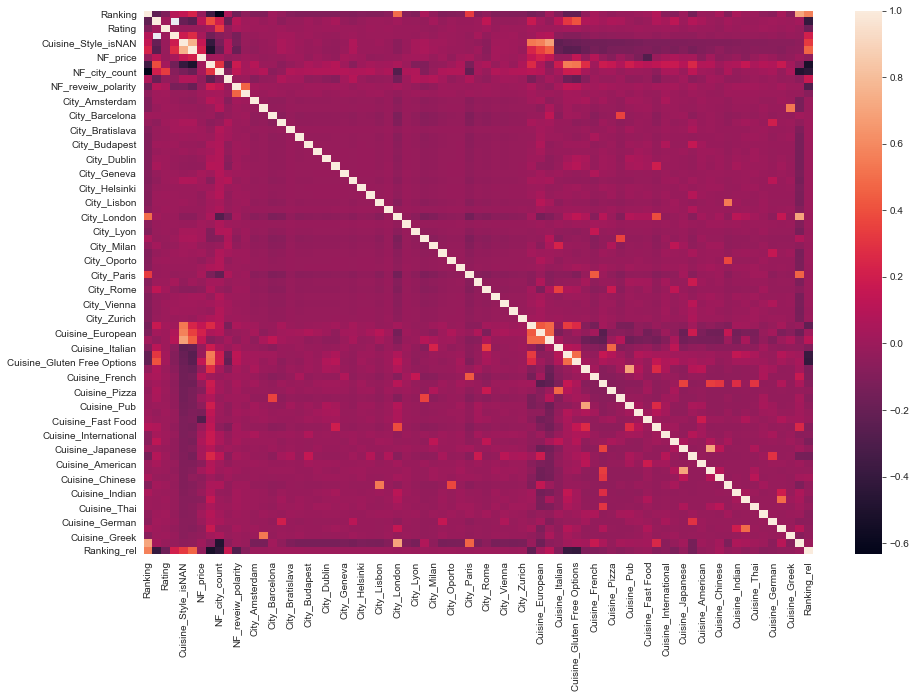

In [35]:
# correlation for data frame with new features
corr = df.drop(['Sample'], axis=1).corr()
display(corr)

# plot the heatmap
plt.figure(figsize=(15,10))
sb.heatmap(corr)

# Preprocessing for training

In [38]:
# replace existing NaN values
fillna_mean(df, 'Number of Reviews')

# keep only numeric columns
df = df.drop(['Restaurant_id', 'City', 'Cuisine Style',
                    'Price Range', 'Reviews', 'URL_TA', 'ID_TA'], axis = 1)

df.describe()

,Ranking,Number of Reviews,Sample,Rating,Number_of_Reviews_isNAN,Cuisine_Style_isNAN,Price_Range_isNAN,NF_price,NF_cuisine_count,NF_city_count,...,Cuisine_Portuguese,Cuisine_Indian,Cuisine_Middle Eastern,Cuisine_Thai,Cuisine_Wine Bar,Cuisine_German,Cuisine_Halal,Cuisine_Greek,City_N_Rank,Ranking_rel
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000
mean,3664.427520,124.471197,0.800000,3.194430,0.064000,0.231800,0.347220,1.879320,2.718700,6.809000,...,0.027700,0.026560,0.019600,0.018460,0.017540,0.016400,0.015460,0.015360,7361.60784,0.498423
std,3700.092452,284.546884,0.400004,1.705453,0.244755,0.421986,0.476091,0.421189,1.790205,4.249965,...,0.164114,0.160795,0.138623,0.134609,0.131273,0.127009,0.123375,0.122981,5288.40218,0.287871
min,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,468.00000,0.000061
25%,972.000000,10.000000,1.000000,3.000000,0.000000,0.000000,0.000000,2.000000,1.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2737.00000,0.249061
50%,2278.000000,38.000000,1.000000,4.000000,0.000000,0.000000,0.000000,2.000000,2.000000,6.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6275.00000,0.496908
75%,5241.000000,124.471197,1.000000,4.500000,0.000000,0.000000,1.000000,2.000000,4.000000,10.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13986.00000,0.747353
max,16444.000000,9660.000000,1.000000,5.000000,1.000000,1.000000,1.000000,3.000000,21.000000,19.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,16444.00000,1.000000


In [39]:
# Normalization
cols_to_norm = ['Ranking', 'Number of Reviews', 'City_N_Rank', 'NF_review_span']

# # mean normalization
# df_train = (df_train-df_train.mean()) / df_train.std()

 # min-max normalization
df[cols_to_norm] = (df[cols_to_norm]-df[cols_to_norm].min()) / \
                         (df[cols_to_norm].max()-df[cols_to_norm].min())

# NB! As it turned out 'Ranking' normalization without grouping by city - not a good idea..

df.describe()

,Ranking,Number of Reviews,Sample,Rating,Number_of_Reviews_isNAN,Cuisine_Style_isNAN,Price_Range_isNAN,NF_price,NF_cuisine_count,NF_city_count,...,Cuisine_Portuguese,Cuisine_Indian,Cuisine_Middle Eastern,Cuisine_Thai,Cuisine_Wine Bar,Cuisine_German,Cuisine_Halal,Cuisine_Greek,City_N_Rank,Ranking_rel
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.222796,0.012681,0.800000,3.194430,0.064000,0.231800,0.347220,1.879320,2.718700,6.809000,...,0.027700,0.026560,0.019600,0.018460,0.017540,0.016400,0.015460,0.015360,0.431498,0.498423
std,0.225025,0.029462,0.400004,1.705453,0.244755,0.421986,0.476091,0.421189,1.790205,4.249965,...,0.164114,0.160795,0.138623,0.134609,0.131273,0.127009,0.123375,0.122981,0.331022,0.287871
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000061
25%,0.059052,0.000828,1.000000,3.000000,0.000000,0.000000,0.000000,2.000000,1.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142026,0.249061
50%,0.138478,0.003727,1.000000,4.000000,0.000000,0.000000,0.000000,2.000000,2.000000,6.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.363483,0.496908
75%,0.318677,0.012681,1.000000,4.500000,0.000000,0.000000,1.000000,2.000000,4.000000,10.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.846144,0.747353
max,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000,1.000000,3.000000,21.000000,19.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# df.describe()
df.info()

# Model training

## Define preprocessed data (not use all-in-one preproc_data function by default)

In [7]:
df_preproc = df
# df_preproc = preproc_data(df)

df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 76 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Ranking                      50000 non-null  float64
 1   Number of Reviews            50000 non-null  float64
 2   Sample                       50000 non-null  int64  
 3   Rating                       50000 non-null  float64
 4   Number_of_Reviews_isNAN      50000 non-null  uint8  
 5   Cuisine_Style_isNAN          50000 non-null  uint8  
 6   Price_Range_isNAN            50000 non-null  uint8  
 7   NF_price                     50000 non-null  float64
 8   NF_cuisine_count             50000 non-null  float64
 9   NF_city_count                50000 non-null  int64  
 10  NF_review_span               50000 non-null  float64
 11  NF_reveiw_polarity           50000 non-null  float64
 12  NF_reveiw_subjectivity       50000 non-null  float64
 13  City_Amsterdam  

In [8]:
# Split train and test
train_data = df_preproc[df_preproc.Sample == 1].drop(['Sample'], axis=1)
test_data = df_preproc[df_preproc.Sample == 0].drop(['Sample'], axis=1)
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 10000 to 49999
Data columns (total 75 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Ranking                      40000 non-null  float64
 1   Number of Reviews            40000 non-null  float64
 2   Rating                       40000 non-null  float64
 3   Number_of_Reviews_isNAN      40000 non-null  uint8  
 4   Cuisine_Style_isNAN          40000 non-null  uint8  
 5   Price_Range_isNAN            40000 non-null  uint8  
 6   NF_price                     40000 non-null  float64
 7   NF_cuisine_count             40000 non-null  float64
 8   NF_city_count                40000 non-null  int64  
 9   NF_review_span               40000 non-null  float64
 10  NF_reveiw_polarity           40000 non-null  float64
 11  NF_reveiw_subjectivity       40000 non-null  float64
 12  City_Amsterdam               40000 non-null  uint8  
 13  City_Athens 

In [15]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = train_data.drop(['Rating'], axis = 1)
y = train_data['Rating']

# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)

# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# Создаём модель
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

#округляем до 0,5 как в фактических оценках
y_pred =  (y_pred * 2).round(0) / 2
print(y_pred)

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


[3.  4.  3.5 ... 4.5 4.5 3.5]
MAE: 0.17795


<AxesSubplot:>

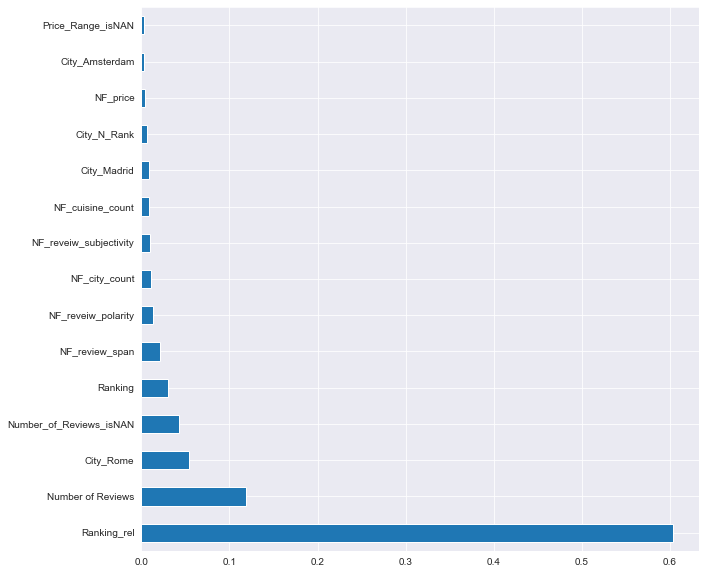

In [10]:
# show the most important features
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Test data prediction

In [16]:
test_data = test_data.drop(['Rating'], axis=1)
test_data.info()

KeyError: "['Rating'] not found in axis"

In [17]:
# predict test data
predict_submission = model.predict(test_data)

# round as in real Rating
predict_submission =  (predict_submission * 2).round(0) / 2
predict_submission

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


array([3.5, 4. , 4.5, ..., 3. , 4.5, 4.5])

In [18]:
sample_submission

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.5
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
...,...,...
9995,id_9995,4.5
9996,id_9996,4.0
9997,id_9997,3.0
9998,id_9998,4.5


In [19]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.5
1,id_1,4.0
2,id_2,4.5
3,id_3,4.0
4,id_4,4.5
5,id_5,4.5
6,id_6,1.5
7,id_7,3.5
8,id_8,4.0
9,id_9,4.5


# Utils

In [ ]:
# delete some columns (just for testing)
n_drop_cols = 14
# Drop last n_drop_cols columns of dataframe
for i in range(n_drop_cols):
        del df_preproc[df_preproc.columns.values[-1]]